Hi everyone! This kernel uses `fastai` to predict the output by using the `Tabular` class. First, we transform the input into some features, then we train a model on the data and finally ensemble the results into a submission. Hope you find it somewhat useful.

In [ ]:
from fastai.tabular import *
from fastai import *

In [ ]:
import datetime

In [ ]:
PATH = Config.data_path()/'competitions/elo-merchant-category-recommendation'
list(PATH.glob("*.csv"))

[PosixPath('/home/achen/.fastai/data/competitions/elo-merchant-category-recommendation/historical_transactions.csv'),
 PosixPath('/home/achen/.fastai/data/competitions/elo-merchant-category-recommendation/merchants.csv'),
 PosixPath('/home/achen/.fastai/data/competitions/elo-merchant-category-recommendation/new_merchant_transactions.csv'),
 PosixPath('/home/achen/.fastai/data/competitions/elo-merchant-category-recommendation/test.csv'),
 PosixPath('/home/achen/.fastai/data/competitions/elo-merchant-category-recommendation/train.csv')]

In [ ]:
train = pd.read_csv(PATH/'train.csv')
test = pd.read_csv(PATH/'test.csv')

In [ ]:
df_hist_trans = pd.read_csv(PATH/'historical_transactions.csv')
df_new_merchant_trans = pd.read_csv(PATH/'new_merchant_transactions.csv')

In [ ]:
train.head().T

,0,1,2,3,4
first_active_month,2017-06,2017-01,2016-08,2017-09,2017-11
card_id,C_ID_92a2005557,C_ID_3d0044924f,C_ID_d639edf6cd,C_ID_186d6a6901,C_ID_cdbd2c0db2
feature_1,5,4,2,4,1
feature_2,2,1,2,3,3
feature_3,1,0,0,0,0
target,-0.820283,0.392913,0.688056,0.142495,-0.159749


In [ ]:
test.head().T

,0,1,2,3,4
first_active_month,2017-04,2017-01,2017-08,2017-12,2015-12
card_id,C_ID_0ab67a22ab,C_ID_130fd0cbdd,C_ID_b709037bc5,C_ID_d27d835a9f,C_ID_2b5e3df5c2
feature_1,3,2,5,2,5
feature_2,3,3,1,1,1
feature_3,1,0,1,0,1


In [ ]:
# Preprocess and merge datasets
# Preprocessing from: https://www.kaggle.com/chauhuynh/my-first-kernel-3-699

In [ ]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['category_2'].fillna(1.0,inplace=True)
    df['category_3'].fillna('A',inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)

In [ ]:
def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [ ]:
# Fastai version of data preprocessing
# add_datepart(df_train, 'first_active_month')
# add_datepart(df_test, 'first_active_month')

In [ ]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0})
    #https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/73244
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']

In [ ]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']

aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
# aggs['authorized_flag'] = ['sum']#, 'mean'] # df_train['hist_authorized_flag_mean'] is all NaN; sum is 0
aggs['weekend'] = ['sum', 'mean']
# aggs['category_1'] = ['sum', 'mean'] # all zeros
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_hist_trans[col+'_mean'] = df_hist_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']    

new_columns = get_new_columns('hist',aggs)
df_hist_trans_group = df_hist_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['hist_purchase_date_diff'] = (df_hist_trans_group['hist_purchase_date_max'] - df_hist_trans_group['hist_purchase_date_min']).dt.days
df_hist_trans_group['hist_purchase_date_average'] = df_hist_trans_group['hist_purchase_date_diff']/df_hist_trans_group['hist_card_id_size']
df_hist_trans_group['hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

172

In [ ]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_new_merchant_trans[col+'_mean'] = df_new_merchant_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']
    
new_columns = get_new_columns('new_hist',aggs)
df_hist_trans_group = df_new_merchant_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['new_hist_purchase_date_diff'] = (df_hist_trans_group['new_hist_purchase_date_max'] - df_hist_trans_group['new_hist_purchase_date_min']).dt.days
df_hist_trans_group['new_hist_purchase_date_average'] = df_hist_trans_group['new_hist_purchase_date_diff']/df_hist_trans_group['new_hist_card_id_size']
df_hist_trans_group['new_hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['new_hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

168

In [ ]:
del df_hist_trans;gc.collect()
del df_new_merchant_trans;gc.collect()

0

In [ ]:
df_train.head(5)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_month_nunique,hist_hour_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,hist_year_nunique,hist_subsector_id_nunique,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_var,hist_installments_sum,hist_installments_max,hist_installments_min,hist_installments_mean,hist_installments_var,hist_purchase_date_max,hist_purchase_date_min,hist_month_lag_max,hist_month_lag_min,hist_month_lag_mean,hist_month_lag_var,hist_month_diff_mean,hist_weekend_sum,hist_weekend_mean,hist_card_id_size,hist_category_2_mean_mean,hist_category_3_mean_mean,hist_purchase_date_diff,hist_purchase_date_average,hist_purchase_date_uptonow,new_hist_month_nunique,new_hist_hour_nunique,new_hist_weekofyear_nunique,new_hist_dayofweek_nunique,new_hist_year_nunique,new_hist_subsector_id_nunique,new_hist_merchant_id_nunique,new_hist_merchant_category_id_nunique,new_hist_purchase_amount_sum,new_hist_purchase_amount_max,new_hist_purchase_amount_min,new_hist_purchase_amount_mean,new_hist_purchase_amount_var,new_hist_installments_sum,new_hist_installments_max,new_hist_installments_min,new_hist_installments_mean,new_hist_installments_var,new_hist_purchase_date_max,new_hist_purchase_date_min,new_hist_month_lag_max,new_hist_month_lag_min,new_hist_month_lag_mean,new_hist_month_lag_var,new_hist_month_diff_mean,new_hist_weekend_sum,new_hist_weekend_mean,new_hist_category_1_sum,new_hist_category_1_mean,new_hist_card_id_size,new_hist_category_2_mean_mean,new_hist_category_3_mean_mean,new_hist_purchase_date_diff,new_hist_purchase_date_average,new_hist_purchase_date_uptonow
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,9,23,35,7,2,21,94,41,-165.968739,2.258395,-0.739395,-0.638341,0.045003,4,1,0,0.015385,0.015206,2018-02-25 09:31:15,2017-06-27 14:18:08,0,-8,-3.911538,5.748901,11.800000,90,0.346154,260,0.072502,0.346719,242,0.930769,357,2.0,8.0,7.0,7.0,1.0,10.0,23.0,14.0,-13.244202,-0.296112,-0.724368,-0.575835,0.018445,0.0,0.0,0.0,0.000000,0.000000,2018-04-29 11:23:05,2018-03-05 14:04:36,2.0,1.0,1.478261,0.260870,11.695652,6.0,0.260870,0.0,0.000000,23.0,-0.550160,-0.592993,54.0,2.347826,294.0
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,12,24,50,7,2,24,142,57,-210.006336,4.630299,-0.742400,-0.600018,0.148200,543,10,-1,1.551429,2.282448,2018-01-31 22:31:09,2017-01-06 16:29:42,0,-12,-5.031429,14.477519,12.817143,132,0.377143,350,0.074568,-0.295163,390,1.114286,381,2.0,5.0,4.0,4.0,1.0,4.0,6.0,5.0,-4.355735,-0.701858,-0.739410,-0.725956,0.000205,6.0,1.0,1.0,1.000000,0.000000,2018-03-30 06:48:26,2018-02-01 17:07:54,2.0,1.0,1.500000,0.300000,12.833333,0.0,0.000000,0.0,0.000000,6.0,-0.550160,-0.606486,56.0,9.333333,324.0
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,10,14,22,7,2,7,13,8,-29.167391,-0.145847,-0.730138,-0.678311,0.007635,0,0,0,0.000000,0.000000,2018-02-27 19:08:25,2017-01-11 08:21:22,0,-13,-8.604651,14.768549,11.790698,11,0.255814,43,-0.087803,0.358458,412,9.581395,354,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.700326,-0.700326,-0.700326,-0.700326,NaN,0.0,0.0,0.0,0.000000,NaN,2018-04-28 17:43:11,2018-04-28 17:43:11,2.0,2.0,2.000000,NaN,11.000000,1.0,1.000000,0.0,0.000000,1.0,-0.549015,-0.592993,0.0,0.000000,294.0
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,6,16,20,7,2,13,50,25,-49.491364,1.445596,-0.740897,-0.642745,0.068447,84,3,-1,1.090909,0.346890,2018-02-28 11:44:40,2017-09-26 16:22:21,0,-5,-2.831169,3.247437,11.714286,11,0.142857,77,-0.086166,-0.338321,154,2.000000,354,2.0,5.0,5.0,4.0,1.0,5.0,7.0,6.0,-4.654372,-0.566740,-0.734135,-0.664910,0.004340,5.0,1.0,-1.0,0.714286,0.571429,2018-04-18 11:00:11,2018-03-07 11:55:06,2.0,1.0,1.714286,0.238095,11.857143,3.0,0.428571,1.0,0.142857,7.0,-0.556518,-0.604559,41.0,5.857143,305.0
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749,4,22,17,7,2,17,66,26,-48.687656,7.193041,-0.746156,-0.366073,1.828160,182,12,1,1.368421,3.598086,2018-02-28 20:40:41,2017-11-12 00:00:

In [ ]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [ ]:
for df in [df_train,df_test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month']) # remove active month afterwards?
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max',\
                     'new_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']

for f in ['feature_1','feature_2','feature_3']:
    order_label = df_train.groupby([f])['outliers'].mean()
    df_train[f] = df_train[f].map(order_label)
    df_test[f] = df_test[f].map(order_label)

In [ ]:
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month','target','outliers']]
target = df_train['target']
# del df_train['target']

In [ ]:
# remove dates
del df_train['first_active_month']

In [ ]:
df_train.head()

,card_id,feature_1,feature_2,feature_3,target,hist_month_nunique,hist_hour_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,hist_year_nunique,hist_subsector_id_nunique,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_var,hist_installments_sum,hist_installments_max,hist_installments_min,hist_installments_mean,hist_installments_var,hist_purchase_date_max,hist_purchase_date_min,hist_month_lag_max,hist_month_lag_min,hist_month_lag_mean,hist_month_lag_var,hist_month_diff_mean,hist_weekend_sum,hist_weekend_mean,hist_card_id_size,hist_category_2_mean_mean,hist_category_3_mean_mean,hist_purchase_date_diff,hist_purchase_date_average,hist_purchase_date_uptonow,new_hist_month_nunique,new_hist_hour_nunique,...,new_hist_year_nunique,new_hist_subsector_id_nunique,new_hist_merchant_id_nunique,new_hist_merchant_category_id_nunique,new_hist_purchase_amount_sum,new_hist_purchase_amount_max,new_hist_purchase_amount_min,new_hist_purchase_amount_mean,new_hist_purchase_amount_var,new_hist_installments_sum,new_hist_installments_max,new_hist_installments_min,new_hist_installments_mean,new_hist_installments_var,new_hist_purchase_date_max,new_hist_purchase_date_min,new_hist_month_lag_max,new_hist_month_lag_min,new_hist_month_lag_mean,new_hist_month_lag_var,new_hist_month_diff_mean,new_hist_weekend_sum,new_hist_weekend_mean,new_hist_category_1_sum,new_hist_category_1_mean,new_hist_card_id_size,new_hist_category_2_mean_mean,new_hist_category_3_mean_mean,new_hist_purchase_date_diff,new_hist_purchase_date_average,new_hist_purchase_date_uptonow,outliers,dayofweek,weekofyear,month,elapsed_time,hist_first_buy,new_hist_first_buy,card_id_total,purchase_amount_total
0,C_ID_92a2005557,0.013145,0.008752,0.011428,-0.820283,9,23,35,7,2,21,94,41,-165.968739,2.258395,-0.739395,-0.638341,0.045003,4,1,0,0.015385,0.015206,1.519551e+09,1.498573e+09,0,-8,-3.911538,5.748901,11.800000,90,0.346154,260,0.072502,0.346719,242,0.930769,357,2.0,8.0,...,1.0,10.0,23.0,14.0,-13.244202,-0.296112,-0.724368,-0.575835,0.018445,0.0,0.0,0.0,0.000000,0.000000,1.525001e+09,1.520259e+09,2.0,1.0,1.478261,0.260870,11.695652,6.0,0.260870,0.0,0.000000,23.0,-0.550160,-0.592993,54.0,2.347826,294.0,0,3,22,6,626,26,277.0,283.0,-179.212942
1,C_ID_3d0044924f,0.010712,0.011385,0.010283,0.392913,12,24,50,7,2,24,142,57,-210.006336,4.630299,-0.742400,-0.600018,0.148200,543,10,-1,1.551429,2.282448,1.517438e+09,1.483720e+09,0,-12,-5.031429,14.477519,12.817143,132,0.377143,350,0.074568,-0.295163,390,1.114286,381,2.0,5.0,...,1.0,4.0,6.0,5.0,-4.355735,-0.701858,-0.739410,-0.725956,0.000205,6.0,1.0,1.0,1.000000,0.000000,1.522393e+09,1.517505e+09,2.0,1.0,1.500000,0.300000,12.833333,0.0,0.000000,0.0,0.000000,6.0,-0.550160,-0.606486,56.0,9.333333,324.0,0,6,52,1,777,5,396.0,356.0,-214.362071
2,C_ID_d639edf6cd,0.010610,0.008752,0.010283,0.688056,10,14,22,7,2,7,13,8,-29.167391,-0.145847,-0.730138,-0.678311,0.007635,0,0,0,0.000000,0.000000,1.519759e+09,1.484123e+09,0,-13,-8.604651,14.768549,11.790698,11,0.255814,43,-0.087803,0.358458,412,9.581395,354,1.0,1.0,...,1.0,1.0,1.0,1.0,-0.700326,-0.700326,-0.700326,-0.700326,NaN,0.0,0.0,0.0,0.000000,NaN,1.524937e+09,1.524937e+09,2.0,2.0,2.000000,NaN,11.000000,1.0,1.000000,0.0,0.000000,1.0,-0.549015,-0.592993,0.0,0.000000,294.0,0,0,31,8,930,163,635.0,44.0,-29.867717
3,C_ID_186d6a6901,0.010712,0.014166,0.010283,0.142495,6,16,20,7,2,13,50,25,-49.491364,1.445596,-0.740897,-0.642745,0.068447,84,3,-1,1.090909,0.346890,1.519818e+09,1.506443e+09,0,-5,-2.831169,3.247437,11.714286,11,0.142857,77,-0.086166,-0.338321,154,2.000000,354,2.0,5.0,...,1.0,5.0,7.0,6.0,-4.654372,-0.566740,-0.734135,-0.664910,0.004340,5.0,1.0,-1.0,0.714286,0.571429,1.524049e+09,1.520424e+09,2.0,1.0,1.714286,0.238095,11.857143,3.0,0.428571,1.0,0.142857,7.0,-0.556518,-0.604559,41.0,5.857143,305.0,0,4,35,9,534,25,187.0,84.0,-54.145736
4,C_ID_cdbd2c0db2,0.008058,0.014166,0.010283,-0

In [ ]:
# Save data
df_train.to_csv('proc-train-data.csv')
df_test.to_csv('proc-test-data.csv')

In [ ]:
# Load Data
df_train = pd.read_csv('proc-train-data.csv', index_col=0, header=0)
df_test = pd.read_csv('proc-test-data.csv', index_col=0, header=0)

In [ ]:
df_train.head()

,card_id,feature_1,feature_2,feature_3,target,hist_month_nunique,hist_hour_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,hist_year_nunique,hist_subsector_id_nunique,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_var,hist_installments_sum,hist_installments_max,hist_installments_min,hist_installments_mean,hist_installments_var,hist_purchase_date_max,hist_purchase_date_min,hist_month_lag_max,hist_month_lag_min,hist_month_lag_mean,hist_month_lag_var,hist_month_diff_mean,hist_weekend_sum,hist_weekend_mean,hist_card_id_size,hist_category_2_mean_mean,hist_category_3_mean_mean,hist_purchase_date_diff,hist_purchase_date_average,hist_purchase_date_uptonow,new_hist_month_nunique,new_hist_hour_nunique,...,new_hist_year_nunique,new_hist_subsector_id_nunique,new_hist_merchant_id_nunique,new_hist_merchant_category_id_nunique,new_hist_purchase_amount_sum,new_hist_purchase_amount_max,new_hist_purchase_amount_min,new_hist_purchase_amount_mean,new_hist_purchase_amount_var,new_hist_installments_sum,new_hist_installments_max,new_hist_installments_min,new_hist_installments_mean,new_hist_installments_var,new_hist_purchase_date_max,new_hist_purchase_date_min,new_hist_month_lag_max,new_hist_month_lag_min,new_hist_month_lag_mean,new_hist_month_lag_var,new_hist_month_diff_mean,new_hist_weekend_sum,new_hist_weekend_mean,new_hist_category_1_sum,new_hist_category_1_mean,new_hist_card_id_size,new_hist_category_2_mean_mean,new_hist_category_3_mean_mean,new_hist_purchase_date_diff,new_hist_purchase_date_average,new_hist_purchase_date_uptonow,outliers,dayofweek,weekofyear,month,elapsed_time,hist_first_buy,new_hist_first_buy,card_id_total,purchase_amount_total
0,C_ID_92a2005557,0.013145,0.008752,0.011428,-0.820283,9,23,35,7,2,21,94,41,-165.968739,2.258395,-0.739395,-0.638341,0.045003,4,1,0,0.015385,0.015206,1.519551e+09,1.498573e+09,0,-8,-3.911538,5.748901,11.800000,90,0.346154,260,0.072502,0.346719,242,0.930769,357,2.0,8.0,...,1.0,10.0,23.0,14.0,-13.244202,-0.296112,-0.724368,-0.575835,0.018445,0.0,0.0,0.0,0.000000,0.000000,1.525001e+09,1.520259e+09,2.0,1.0,1.478261,0.260870,11.695652,6.0,0.260870,0.0,0.000000,23.0,-0.550160,-0.592993,54.0,2.347826,294.0,0,3,22,6,626,26,277.0,283.0,-179.212942
1,C_ID_3d0044924f,0.010712,0.011385,0.010283,0.392913,12,24,50,7,2,24,142,57,-210.006336,4.630299,-0.742400,-0.600018,0.148200,543,10,-1,1.551429,2.282448,1.517438e+09,1.483720e+09,0,-12,-5.031429,14.477519,12.817143,132,0.377143,350,0.074568,-0.295163,390,1.114286,381,2.0,5.0,...,1.0,4.0,6.0,5.0,-4.355735,-0.701858,-0.739410,-0.725956,0.000205,6.0,1.0,1.0,1.000000,0.000000,1.522393e+09,1.517505e+09,2.0,1.0,1.500000,0.300000,12.833333,0.0,0.000000,0.0,0.000000,6.0,-0.550160,-0.606486,56.0,9.333333,324.0,0,6,52,1,777,5,396.0,356.0,-214.362071
2,C_ID_d639edf6cd,0.010610,0.008752,0.010283,0.688056,10,14,22,7,2,7,13,8,-29.167391,-0.145847,-0.730138,-0.678311,0.007635,0,0,0,0.000000,0.000000,1.519759e+09,1.484123e+09,0,-13,-8.604651,14.768549,11.790698,11,0.255814,43,-0.087803,0.358458,412,9.581395,354,1.0,1.0,...,1.0,1.0,1.0,1.0,-0.700326,-0.700326,-0.700326,-0.700326,NaN,0.0,0.0,0.0,0.000000,NaN,1.524937e+09,1.524937e+09,2.0,2.0,2.000000,NaN,11.000000,1.0,1.000000,0.0,0.000000,1.0,-0.549015,-0.592993,0.0,0.000000,294.0,0,0,31,8,930,163,635.0,44.0,-29.867717
3,C_ID_186d6a6901,0.010712,0.014166,0.010283,0.142495,6,16,20,7,2,13,50,25,-49.491364,1.445596,-0.740897,-0.642745,0.068447,84,3,-1,1.090909,0.346890,1.519818e+09,1.506443e+09,0,-5,-2.831169,3.247437,11.714286,11,0.142857,77,-0.086166,-0.338321,154,2.000000,354,2.0,5.0,...,1.0,5.0,7.0,6.0,-4.654372,-0.566740,-0.734135,-0.664910,0.004340,5.0,1.0,-1.0,0.714286,0.571429,1.524049e+09,1.520424e+09,2.0,1.0,1.714286,0.238095,11.857143,3.0,0.428571,1.0,0.142857,7.0,-0.556518,-0.604559,41.0,5.857143,305.0,0,4,35,9,534,25,187.0,84.0,-54.145736
4,C_ID_cdbd2c0db2,0.008058,0.014166,0.010283,-0

In [ ]:
# Create Databunch

In [ ]:
cat_names = ['card_id', 'feature_1', 'feature_2', 'feature_3', 'hist_month_nunique', 'hist_hour_nunique', 'hist_weekofyear_nunique', 
             'hist_dayofweek_nunique', 'hist_year_nunique', 'hist_subsector_id_nunique', 'hist_merchant_id_nunique', 'hist_merchant_category_id_nunique',
             'hist_category_2_mean_mean', 'hist_category_3_mean_mean', 'hist_purchase_date_uptonow', 'new_hist_month_nunique', 'new_hist_hour_nunique', 
             'new_hist_weekofyear_nunique', 'new_hist_dayofweek_nunique', 'new_hist_year_nunique', 'new_hist_subsector_id_nunique', 'new_hist_merchant_id_nunique',
             'new_hist_merchant_category_id_nunique', 'dayofweek', 'weekofyear', 'month' # 'outliers',
            ]
cont_names = ['hist_purchase_amount_sum', 'hist_purchase_amount_max', 'hist_purchase_amount_min', 'hist_purchase_amount_mean', 
              'hist_purchase_amount_var', 'hist_installments_sum', 'hist_installments_max', 'hist_installments_min', 'hist_installments_mean',
              'hist_installments_var', 'hist_purchase_date_max', 'hist_purchase_date_min', 'hist_month_lag_max', 'hist_month_lag_min', 'hist_month_lag_mean', 
              'hist_month_lag_var', 'hist_month_diff_mean', 'hist_weekend_sum', 'hist_weekend_mean', 'hist_card_id_size', 'hist_purchase_date_diff', 
              'hist_purchase_date_average', 'new_hist_purchase_amount_sum', 'new_hist_purchase_amount_max', 'new_hist_purchase_amount_min', 
              'new_hist_purchase_amount_mean', 'new_hist_purchase_amount_var', 'new_hist_installments_sum', 'new_hist_installments_max', 'new_hist_installments_min',
              'new_hist_installments_mean', 'new_hist_installments_var', 'new_hist_purchase_date_max', 'new_hist_month_lag_max', 'new_hist_month_lag_min', 
              'new_hist_month_lag_mean', 'new_hist_month_lag_var', 'new_hist_month_diff_mean', 'new_hist_weekend_sum', 'new_hist_weekend_mean', 
              'new_hist_category_1_sum', 'new_hist_category_1_mean', 'new_hist_card_id_size', 'new_hist_category_2_mean_mean', 'new_hist_category_3_mean_mean',
              'new_hist_purchase_date_diff', 'new_hist_purchase_date_average', 'new_hist_purchase_date_uptonow', 'elapsed_time', 'hist_first_buy', 'new_hist_first_buy',
              'card_id_total', 'purchase_amount_total', 'new_hist_purchase_date_min'
             ]

In [ ]:
for cat in df_train.columns:
    if cat not in cat_names and cat not in cont_names:
        print(cat)
        
for cat in cat_names:
    if cat not in df_train.columns:
        print(cat)
        
for cat in cont_names:
    if cat not in df_train.columns:
        print(cat)

target
outliers


In [ ]:
len(df_train)

201917

In [ ]:
dep_var = 'target'
procs = [FillMissing, Categorify, Normalize]

In [ ]:
df_test[cont_names] = df_test[cont_names].fillna(df_test[cont_names].median(axis=0))
del df_train['outliers']

In [ ]:
test_data = TabularList.from_df(df_test, path=".", cat_names=cat_names, cont_names=cont_names, procs=procs)

In [ ]:
data = (TabularList.from_df(df_train, path=".", cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .random_split_by_pct(0.20)
                           .label_from_df(cols=dep_var)
                           .add_test(test_data)
                           .databunch(bs=4096))

In [ ]:
data.show_batch(rows=10)

card_id,feature_1,feature_2,feature_3,hist_month_nunique,hist_hour_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,hist_year_nunique,hist_subsector_id_nunique,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_category_2_mean_mean,hist_category_3_mean_mean,hist_purchase_date_uptonow,new_hist_month_nunique,new_hist_hour_nunique,new_hist_weekofyear_nunique,new_hist_dayofweek_nunique,new_hist_year_nunique,new_hist_subsector_id_nunique,new_hist_merchant_id_nunique,new_hist_merchant_category_id_nunique,dayofweek,weekofyear,month,new_hist_purchase_amount_sum_na,new_hist_purchase_amount_max_na,new_hist_purchase_amount_min_na,new_hist_purchase_amount_mean_na,new_hist_purchase_amount_var_na,new_hist_installments_sum_na,new_hist_installments_max_na,new_hist_installments_min_na,new_hist_installments_mean_na,new_hist_installments_var_na,new_hist_month_lag_max_na,new_hist_month_lag_min_na,new_hist_month_lag_mean_na,new_hist_month_lag_var_na,new_hist_month_diff_mean_na,new_hist_weekend_sum_na,new_hist_weekend_mean_na,new_hist_category_1_sum_na,new_hist_category_1_mean_na,new_hist_card_id_size_na,new_hist_category_2_mean_mean_na,new_hist_category_3_mean_mean_na,new_hist_purchase_date_diff_na,new_hist_purchase_date_average_na,new_hist_purchase_date_uptonow_na,new_hist_first_buy_na,card_id_total_na,purchase_amount_total_na,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_var,hist_installments_sum,hist_installments_max,hist_installments_min,hist_installments_mean,hist_installments_var,hist_purchase_date_max,hist_purchase_date_min,hist_month_lag_max,hist_month_lag_min,hist_month_lag_mean,hist_month_lag_var,hist_month_diff_mean,hist_weekend_sum,hist_weekend_mean,hist_card_id_size,hist_purchase_date_diff,hist_purchase_date_average,new_hist_purchase_amount_sum,new_hist_purchase_amount_max,new_hist_purchase_amount_min,new_hist_purchase_amount_mean,new_hist_purchase_amount_var,new_hist_installments_sum,new_hist_installments_max,new_hist_installments_min,new_hist_installments_mean,new_hist_installments_var,new_hist_purchase_date_max,new_hist_month_lag_max,new_hist_month_lag_min,new_hist_month_lag_mean,new_hist_month_lag_var,new_hist_month_diff_mean,new_hist_weekend_sum,new_hist_weekend_mean,new_hist_category_1_sum,new_hist_category_1_mean,new_hist_card_id_size,new_hist_category_2_mean_mean,new_hist_category_3_mean_mean,new_hist_purchase_date_diff,new_hist_purchase_date_average,new_hist_purchase_date_uptonow,elapsed_time,hist_first_buy,new_hist_first_buy,card_id_total,purchase_amount_total,new_hist_purchase_date_min,target
C_ID_badd3692c6,0.013144615384615385,0.008752121220219405,0.011427520622077443,6,14,22,7,1,10,42,13,0.0745678963053503,0.3481468975981956,598,1.0,4.0,2.0,4.0,1.0,3.0,5.0,5.0,5,39,10,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,-0.0048,-0.0049,-0.0728,-0.0030,-0.0025,-0.5631,-0.1388,-0.0784,-0.7638,-0.0211,-2.6619,-1.1048,0.2602,0.7490,0.6060,-0.5986,2.9198,-0.2823,-0.4345,-0.1448,-0.5639,-0.5332,-0.0075,-0.3819,-0.1705,-0.3635,-0.0377,-0.5641,-0.6268,-0.2978,-0.6492,-0.2468,0.3447,0.4433,2.4645,1.6690,-1.8171,3.1472,-0.7575,-1.0638,-0.3442,-0.2813,-0.2508,0.3375,-0.3931,-1.0740,-0.7218,3.0769,0.3612,-0.1149,-0.2476,-0.1635,-0.0045,0.3452,-33.21928024291992
C_ID_5acad4b184,0.010479387818900955,0.008752121220219405,0.011427520622077443,6,6,10,6,2,6,9,6,0.07456789630535039,0.16770437076455194,387,2.0,3.0,3.0,3.0,1.0,3.0,3.0,3.0,0,18,5,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,-0.0021,-0.0050,-0.0106,-0.0031,-0.0025,-0.5433,-0.1388,-0.0784,-0.5515,-0.0207,0.1612,-0.0665,0.2602,-0.0320,-0.1136,-0.3570,-0.1205,-0.6610,0.4106,-0.7382,0.1721,2.2899,0.3713,-0.3440,-0.1132,-0.2948,-0.0376,-0.5641,-0.6268,-0.

In [ ]:
# Create a tabular learner Model

In [ ]:
y_range = [df_train['target'].min()*1.3, df_train['target'].max()*1.3]
y_range

[-43.185065234999996, 23.354588919999998]

In [ ]:
learn = tabular_learner(data, layers=[1000,500], metrics=rmse, callback_fns=[callbacks.SaveModelCallback],
                        wd=1, emb_drop=0.1, ps=[5e-3, 5e-2], y_range=y_range)

In [ ]:
# Find learning rate
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


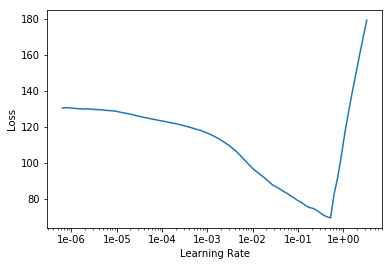

In [ ]:
learn.recorder.plot()

In [ ]:
# Train!
learn.fit_one_cycle(20,5e-2)

epoch,train_loss,valid_loss,root_mean_squared_error
1,59.863167,17.054684,4.172500
2,28.209343,15.070022,3.968746
3,15.912895,14.949982,3.929806
4,10.135908,15.690467,3.974110
5,8.204330,15.662115,4.019009
6,9.710347,15.061714,3.945788
7,9.927436,15.322894,3.984329
8,9.775450,14.791638,3.958273
9,9.827875,15.507010,4.045331
10,9.868713,16.280527,4.264102


In [ ]:
# Grab some predictions for ensembling
preds_1,tgt_1 = learn.get_preds(DatasetType.Test)

In [ ]:
# Sometimes you can add this section after initial training
# learn.callback_fns.append(callbacks.SaveModelCallback)`
# learn.callback_fns

In [ ]:
learn.fit_one_cycle(10,1e-3)

epoch,train_loss,valid_loss,root_mean_squared_error
1,11.780732,15.000435,3.909041
2,9.871683,14.797815,3.911619
3,7.362062,14.702791,3.925976
4,5.029229,14.671383,3.936718
5,3.244857,14.646138,3.944366
6,2.051067,14.702771,3.936017
7,1.314373,14.686519,3.937221
8,0.858186,14.663313,3.947553
9,0.612103,14.652007,3.946446
10,0.474439,14.647005,3.948413


In [ ]:
rmse(*learn.get_preds())

tensor(3.9476)

In [ ]:
learn.fit_one_cycle(15,1e-4)

epoch,train_loss,valid_loss,root_mean_squared_error
1,1.194218,14.661196,3.955986
2,1.159716,14.680349,3.961576
3,1.089722,14.701036,3.961942
4,1.017716,14.711968,3.958025
5,0.942672,14.688317,3.951928
6,0.851374,14.717378,3.957421
7,0.769594,14.697308,3.957980
8,0.690988,14.693104,3.954792
9,0.627560,14.695907,3.958854
10,0.586401,14.695225,3.957068


In [ ]:
rmse(*learn.get_preds())

tensor(3.9592)

In [ ]:
learn.fit_one_cycle(15,1e-5)

epoch,train_loss,valid_loss,root_mean_squared_error
1,1.151301,14.657056,3.955383
2,1.160267,14.664754,3.956153
3,1.142812,14.660799,3.958071
4,1.138721,14.664856,3.958805
5,1.114273,14.671327,3.960862
6,1.114048,14.685786,3.962614
7,1.092439,14.684781,3.961765
8,1.058261,14.696263,3.964375
9,1.052757,14.692532,3.967573
10,1.051739,14.712760,3.963245


In [ ]:
learn.fit_one_cycle(20,5e-7)

epoch,train_loss,valid_loss,root_mean_squared_error
1,1.175611,14.659603,3.954420
2,1.169214,14.657931,3.957088
3,1.181355,14.652312,3.956949
4,1.161226,14.661722,3.955355
5,1.165194,14.652119,3.954745
6,1.161981,14.659352,3.957777
7,1.158350,14.656745,3.959787
8,1.150697,14.652241,3.955959
9,1.143445,14.662773,3.956999
10,1.144127,14.656708,3.957378


In [ ]:
rmse(*learn.get_preds())

tensor(3.9638)

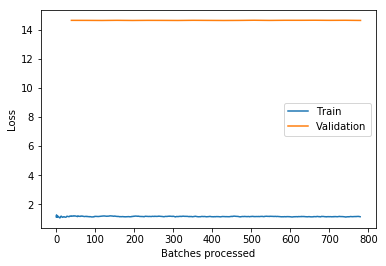

In [ ]:
learn.recorder.plot_losses()

In [ ]:
# Check sample submission
samp = pd.read_csv(path/'sample_submission.csv')
samp.head()

,card_id,target
0,C_ID_0ab67a22ab,0
1,C_ID_130fd0cbdd,0
2,C_ID_b709037bc5,0
3,C_ID_d27d835a9f,0
4,C_ID_2b5e3df5c2,0


In [ ]:
# Predict on test set
preds,tgt = learn.get_preds(DatasetType.Test)

In [ ]:
preds.median(), preds.mean(), preds.max(), preds.min()

(tensor(-0.2272), tensor(-0.3377), tensor(1.8879), tensor(-26.7247))

In [ ]:
test_reload_subm = pd.read_csv(path/'test.csv')

In [ ]:
subm = pd.DataFrame({'card_id': test_reload_subm['card_id'], 'target': preds.squeeze()})
subm.head()

,card_id,target
0,C_ID_0ab67a22ab,-0.753452
1,C_ID_130fd0cbdd,-0.488537
2,C_ID_b709037bc5,-3.169628
3,C_ID_d27d835a9f,-0.414268
4,C_ID_2b5e3df5c2,-0.464695


In [ ]:
subm2 = pd.DataFrame({'card_id': test_reload_subm['card_id'], 'target': preds_1.squeeze()})
subm2.head()

,card_id,target
0,C_ID_0ab67a22ab,-0.847923
1,C_ID_130fd0cbdd,-0.025734
2,C_ID_b709037bc5,-1.143173
3,C_ID_d27d835a9f,1.462082
4,C_ID_2b5e3df5c2,0.225327


In [ ]:
# Save multiple predictions so that you can ensemble at the end

In [ ]:
s_n = 1
# s_n += 1
# s_n

In [ ]:
subm.to_csv(f'subm{s_n}.csv', index=False)
subm2.to_csv(f'subm2.csv', index=False) # Comment this out

In [ ]:
# Confirm it saved correctly
c = pd.read_csv(f'subm{s_n}.csv')
c.head()

,card_id,target
0,C_ID_0ab67a22ab,-0.753452
1,C_ID_130fd0cbdd,-0.488537
2,C_ID_b709037bc5,-3.169628
3,C_ID_d27d835a9f,-0.414269
4,C_ID_2b5e3df5c2,-0.464695


In [ ]:
# Download individual results from kaggle kernel
# from IPython.display import FileLink

In [ ]:
# FileLink(f'subm{s_n}.csv')

In [ ]:
# Ensemble some predictions

In [ ]:
!ls

__notebook__.ipynb  models		proc-train-data.csv  subm2.csv
__output__.json     proc-test-data.csv	subm1.csv


In [ ]:
s1 = pd.read_csv('subm1.csv')
s2 = pd.read_csv('subm2.csv')
# s3 = pd.read_csv('subm3.csv')
# s4 = pd.read_csv('subm4.csv')
# s5 = pd.read_csv('subm5.csv')

In [ ]:
s_all = pd.concat([s1,s2['target']],axis=1) #,s3['target'],s4['target'],s5['target']],axis=1)
s_all.head()

,card_id,target,target
0,C_ID_0ab67a22ab,-0.753452,-0.847923
1,C_ID_130fd0cbdd,-0.488537,-0.025734
2,C_ID_b709037bc5,-3.169628,-1.143173
3,C_ID_d27d835a9f,-0.414269,1.462082
4,C_ID_2b5e3df5c2,-0.464695,0.225327


In [ ]:
s_all.describe().T

,count,mean,std,min,25%,50%,75%,max
target,123623.0,-0.337716,0.766926,-26.724665,-0.522596,-0.227173,0.044855,1.887882
target,123623.0,-0.155304,0.704149,-15.447132,-0.351761,-0.007675,0.209541,2.599010


In [ ]:
s_all.describe().T.describe()

,count,mean,std,min,25%,50%,75%,max
count,2.0,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,123623.0,-0.246510,0.735537,-21.085898,-0.437179,-0.117424,0.127198,2.243446
std,0.0,0.128985,0.044390,7.974420,0.120799,0.155208,0.116451,0.502844
min,123623.0,-0.337716,0.704149,-26.724665,-0.522596,-0.227173,0.044855,1.887882
25%,123623.0,-0.292113,0.719843,-23.905282,-0.479887,-0.172298,0.086027,2.065664
50%,123623.0,-0.246510,0.735537,-21.085898,-0.437179,-0.117424,0.127198,2.243446
75%,123623.0,-0.200907,0.751231,-18.266515,-0.394470,-0.062550,0.168370,2.421228
max,123623.0,-0.155304,0.766926,-15.447132,-0.351761,-0.007675,0.209541,2.599010


In [ ]:
s_all_mean = s_all.mean(axis=1)
s_all_mean.head()

0   -0.800688
1   -0.257135
2   -2.156401
3    0.523907
4   -0.119684
dtype: float64

In [ ]:
subm_ens = pd.DataFrame({'card_id': test_reload_subm['card_id'], 'target': s_all_mean})
subm_ens.to_csv(f'subm_ens.csv', index=False)